## **1. Import the necessary libraries** ---

In [1]:
import matplotlib
import sklearn
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import tensorflow as tf


from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers

print("Versions of key libraries")
print("---")
print("tensorflow: ", tf.__version__)
print("numpy:      ", np.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn:    ", sklearn.__version__)

Versions of key libraries
---
tensorflow:  2.6.0
numpy:       1.19.2
matplotlib:  3.3.4
sklearn:     0.24.2


## **2.Create a function to plot image without axis** ---

In [2]:
def implt(img):
    plt.figure()
    plt.imshow(img)
    plt.axis('off')

print(implt)

<function implt at 0x00000255BCE1E1E0>


## **3. Set matplotlib to have seaborn plot style**

In [3]:
plt.style.use('seaborn')                   # if want to use the default style, set 'classic'
plt.rcParams['ytick.right']     = True
plt.rcParams['ytick.labelright']= True
plt.rcParams['ytick.left']      = False
plt.rcParams['ytick.labelleft'] = False
plt.rcParams['figure.figsize']  = [7,7]   # Set the figure size to be 7 inch for (width,height)

print("Matplotlib setup completes.")

Matplotlib setup completes.


## **4. Prepare data for training and testing**
---
* Step 1: Load the images
* Step 2: Check the shape and type of the data
* Step 3: Convert the data into float32 and rescale the values from the range of 0\~255 into 0\~1
* Step 4: Retrieve the row size and the column size of each image
* Step 5: Perform one-hot enconding on the labels
* Step 6: Retrieve the number of classes in this problem

In [4]:
from imutils import paths
import os, sys
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

def collect_images_and_labels(path_to_images):
    # in seguito, usare https://keras.io/api/preprocessing/image/
    """
        :param path_to_images should be the root folder, in which there is a folder for each label, and the folder's name is
        the label itself
        :return: a list with images and a list with labels
        """
    data = []
    labels = []

    for img_path in list(paths.list_images(path_to_images)):
        # extract the class label from the filename
        label = img_path.split(os.path.sep)[-2]

        # load the input image as (128x128) and preprocess it
        image = load_img(img_path, target_size=(128, 128))
        image = img_to_array(image)
        #image = preprocess_input(image)

        # update the data and labels lists, respectively
        data.append(image)
        labels.append(label)

    return data, labels

def preprocess_labels(labels):
    """
    :param labels: list of string
    :return: np array of 0/1
    """
    lb = LabelBinarizer()
    labels = lb.fit_transform(labels)
    labels = to_categorical(labels)
    return labels

def tts_split(data, labels):
    (x_train, x_test, y_train, y_test) = train_test_split(data, labels, test_size=0.20, stratify=labels,
                                                          random_state=42)
    (x_train, x_test, y_train, y_test) = (np.array(x_train), np.array(x_test), np.array(y_train), np.array(y_test))
    return x_train, x_test, y_train, y_test

PATH_TO_IMAGE = "../data"
MODELS_PATH = "../models"

# Step 1

data, labels = collect_images_and_labels(PATH_TO_IMAGE)
#labels = preprocess_labels(labels)
trDat, tsDat, trLbl, tsLbl = tts_split(data, labels)


# Step 2
print("The shape of trDat is", trDat.shape, "and the type of trDat is", trDat.dtype)
print("The shape of tsDat is", tsDat.shape, "and the type of tsDat is", tsDat.dtype)
print("")
print("The shape of trLbl is", trLbl.shape, "and the type of trLbl is", trLbl.dtype)
print("The shape of tsLbl is", tsLbl.shape, "and the type of tsLbl is", tsLbl.dtype)


# Step 3
trDat           = trDat.astype('float32')/255
tsDat           = tsDat.astype('float32')/255

# Step 4
imgrows         = trDat.shape[1]
imgclms         = trDat.shape[2]
channel         = trDat.shape[3]

# Step 5
trLbl           = preprocess_labels(trLbl)
tsLbl           = preprocess_labels(tsLbl)

# Step 6
num_classes     = tsLbl.shape[1]           

C:\Users\Sanje\anaconda3\envs\tensorflow-gpu\lib\site-packages\PIL\Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


The shape of trDat is (6042, 128, 128, 3) and the type of trDat is float32
The shape of tsDat is (1511, 128, 128, 3) and the type of tsDat is float32

The shape of trLbl is (6042,) and the type of trLbl is <U12
The shape of tsLbl is (1511,) and the type of tsLbl is <U12


## **5.1. Define the CNN model (Add Residual Layers)**
___
* Step 1: Setup the optimizer to be used for training
* Step 2: Set a name for the coming model (required for saving)
* Step 3: Function to create layers for the resnet
* Step 4: Function to create residual blocks
* Step 5: Define the resnet model (to be completed)
* Step 6: Create models for training and testing
* Step 7: Display the summary of the model of interest 

In [5]:
from tensorflow.keras.initializers import he_normal
optmz       = optimizers.Adam(lr=0.001)                                       
modelname   = 'DetecitveMask'                                               

                                                                              
def resLyr(inputs,
           numFilters=16,
           kernelSz=3,
           strides=1,
           activation='relu',
           batchNorm=True,
           convFirst=True,
           lyrName=None):

    convLyr     = Conv2D(numFilters,
                         kernel_size=kernelSz,
                         strides=strides,
                         padding='same',
                         kernel_initializer='he_normal',
                         kernel_regularizer=l2(1e-4),
                         name=lyrName+'_conv' if lyrName else None)
    x           = inputs
    
    if convFirst:
        x       = convLyr(x)
        
        if batchNorm:
            x   = BatchNormalization(name=lyrName+'_bn' if lyrName else None)(x)
            
        if activation is not None:
            x   = Activation(activation,
                             name=lyrName+'_'+activation if lyrName else None)(x)
    else:
        if batchNorm:
            x   = BatchNormalization(name=lyrName+'_bn' if lyrName else None)(x)
            
        if activation is not None:
            x   = Activation(activation,
                             name=lyrName+'_'+activation if lyrName else None)(x)
            
        x       = convLyr(x)
    return x

                                                                               
def resBlkV1(inputs,
             numFilters=16,
             numBlocks=3,
             downsampleOnFirst=True,
             names=None):
    
    x       = inputs
    
    for run in range(0,numBlocks):
        strides = 1
        blkStr  = str(run+1)
        
        if downsampleOnFirst and run == 0:
            strides     = 2
            
        y       = resLyr(inputs=x,
                         numFilters=numFilters,
                         strides=strides,
                         lyrName=names+'_Blk'+blkStr+'_Res1' if names else None)
        y       = resLyr(inputs=y,
                         numFilters=numFilters,
                         activation=None,
                         lyrName=names+'_Blk'+blkStr+'_Res2' if names else None)
        
        if downsampleOnFirst and run == 0:
            x   = resLyr(inputs=x,
                         numFilters=numFilters,
                         kernelSz=1,
                         strides=strides,
                         activation=None,
                         batchNorm=False,
                         lyrName=names+'_Blk'+blkStr+'_lin' if names else None)

        x       = add([x,y],
                      name=names+'_Blk'+blkStr+'_add' if names else None)
        x       = Activation('relu',
                             name=names+'_Blk'+blkStr+'_relu' if names else None)(x)
        
    return x
    

C:\Users\Sanje\anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [6]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import add
from tensorflow.keras.layers import AveragePooling2D

def createResNetV1():
    inputs = Input(shape=(imgrows, imgclms, channel))
    v = resLyr(inputs, numFilters=128, lyrName='Inpt')
    v = resBlkV1(inputs=v,
                 numFilters=128,
                 numBlocks=3,
                 downsampleOnFirst=False,
                 names='Stg1')
    v = resBlkV1(inputs=v,
                 numFilters=64,
                 numBlocks=3,
                 downsampleOnFirst=True,
                 names='Stg2')
    v = resBlkV1(inputs=v,
                 numFilters=32,
                 numBlocks=3,
                 downsampleOnFirst=True,
                 names='Stg3')
    v = AveragePooling2D(pool_size=8, name='AvgPool')(v)
    v = Flatten()(v)
    v = Dense(64, activation='relu', kernel_initializer=he_normal(33), kernel_regularizer=regularizers.l2(1e-4))(v)
    v = Dropout(0.5)(v)
    v = Dense(32, activation='relu', kernel_initializer=he_normal(33), kernel_regularizer=regularizers.l2(1e-4))(v)
    v = Dropout(0.5)(v)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(v)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy',
                  optimizer=optmz,
                  metrics=['accuracy'])
    return model

                                                                               
model       = createResNetV1()  # This is meant for training
modelGo     = createResNetV1()  # This is used for final testing

model.summary()    

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Inpt_conv (Conv2D)              (None, 128, 128, 128 3584        input_1[0][0]                    
__________________________________________________________________________________________________
Inpt_bn (BatchNormalization)    (None, 128, 128, 128 512         Inpt_conv[0][0]                  
__________________________________________________________________________________________________
Inpt_relu (Activation)          (None, 128, 128, 128 0           Inpt_bn[0][0]                    
______________________________________________________________________________________________

## **5.1. Create Learning Scheduler**
___

In [7]:
from tensorflow.keras.callbacks import LearningRateScheduler

def lrSchedule(epoch):
    lr  = 1e-3
    
    if epoch > 160:
        lr  *= 0.5e-3        
    elif epoch > 140:
        lr  *= 1e-3       
    elif epoch > 120:
        lr  *= 1e-2     
    elif epoch > 80:
        lr  *= 1e-1
        
    print('Learning rate: ', lr)
    return lr

LRScheduler     = LearningRateScheduler(lrSchedule)

## **6. Create the checkpoints to be applied during training**
---
* Step 1: Create a checkpoint to save the model from an epoch when validation accuracy is the highest
* Step 2: Create a checkpoint to save the training loss, training accuracy, validation loss and validation accuracy of each epoch into a csv file
* Step 3: Put the two checkpoint objects into a list

In [8]:
# Step 1
folderpath      = MODELS_PATH + '/cnn_v7/'
filepath        = folderpath + modelname + ".hdf5"
checkpoint      = ModelCheckpoint(filepath, 
                                  monitor='val_accuracy', 
                                  verbose=0, 
                                  save_best_only=True, 
                                  mode='max')

# Step 2
csv_logger      = CSVLogger(folderpath+modelname +'.csv')

# Step 3
callbacks_list  = [checkpoint,csv_logger,LRScheduler]                                       

print("Callbacks created:")
print(callbacks_list[0])
print(callbacks_list[1])
print('')
print("Path to model:", filepath)
print("Path to log:  ", folderpath+modelname+'.csv')

Callbacks created:

Path to model: ../models/cnn_v7/DetecitveMask.hdf5
Path to log:   ../models/cnn_v7/DetecitveMask.csv


## **7. Train the deep learning model**

In [10]:

model.fit(trDat,                    # Training data
          trLbl,                            # Training label
          validation_data=(tsDat, tsLbl),   # Validation data and label
          epochs=100,                       # The amount of epochs to be trained
          batch_size=16,                   
          shuffle=True,                     # To shuffle the training data
          callbacks=callbacks_list)         # Callbacks to execute the checkpoints

Epoch 1/100
Learning rate:  0.001
378/378 [==============================] - 53s 140ms/step - loss: 0.8945 - accuracy: 0.7711 - val_loss: 1.0350 - val_accuracy: 0.8240
Epoch 2/100


C:\Users\Sanje\anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Learning rate:  0.001
378/378 [==============================] - 52s 137ms/step - loss: 0.6914 - accuracy: 0.8491 - val_loss: 0.5910 - val_accuracy: 0.8795
Epoch 3/100
Learning rate:  0.001
378/378 [==============================] - 52s 137ms/step - loss: 0.5934 - accuracy: 0.8861 - val_loss: 0.6127 - val_accuracy: 0.9140
Epoch 4/100
Learning rate:  0.001
378/378 [==============================] - 52s 137ms/step - loss: 0.5390 - accuracy: 0.9083 - val_loss: 0.4823 - val_accuracy: 0.9159
Epoch 5/100
Learning rate:  0.001
378/378 [==============================] - 52s 137ms/step - loss: 0.4722 - accuracy: 0.9181 - val_loss: 0.4652 - val_accuracy: 0.9252
Epoch 6/100
Learning rate:  0.001
378/378 [==============================] - 52s 137ms/step - loss: 0.4230 - accuracy: 0.9249 - val_loss: 0.4162 - val_accuracy: 0.9285
Epoch 7/100
Learning rate:  0.001
378/378 [==============================] - 50s 134ms/step - loss: 0.3940 - accuracy: 0.9348 - val_loss: 0.3758 - val_accuracy: 0.9451
Epoc

378/378 [==============================] - 50s 133ms/step - loss: 0.1327 - accuracy: 0.9793 - val_loss: 0.1715 - val_accuracy: 0.9702
Epoch 51/100
Learning rate:  0.001
378/378 [==============================] - 50s 133ms/step - loss: 0.1089 - accuracy: 0.9854 - val_loss: 0.2174 - val_accuracy: 0.9715
Epoch 52/100
Learning rate:  0.001
378/378 [==============================] - 50s 133ms/step - loss: 0.1151 - accuracy: 0.9853 - val_loss: 0.1915 - val_accuracy: 0.9689
Epoch 53/100
Learning rate:  0.001
378/378 [==============================] - 50s 133ms/step - loss: 0.1061 - accuracy: 0.9864 - val_loss: 0.1462 - val_accuracy: 0.9749
Epoch 54/100
Learning rate:  0.001
378/378 [==============================] - 50s 133ms/step - loss: 0.1072 - accuracy: 0.9856 - val_loss: 0.1777 - val_accuracy: 0.9729
Epoch 55/100
Learning rate:  0.001
378/378 [==============================] - 50s 133ms/step - loss: 0.1044 - accuracy: 0.9874 - val_loss: 0.1758 - val_accuracy: 0.9702
Epoch 56/100
Learning

378/378 [==============================] - 50s 133ms/step - loss: 0.0465 - accuracy: 0.9992 - val_loss: 0.1739 - val_accuracy: 0.9801
Epoch 99/100
Learning rate:  0.0001
378/378 [==============================] - 50s 133ms/step - loss: 0.0476 - accuracy: 0.9980 - val_loss: 0.1896 - val_accuracy: 0.9841
Epoch 100/100
Learning rate:  0.0001
378/378 [==============================] - 50s 133ms/step - loss: 0.0449 - accuracy: 0.9992 - val_loss: 0.1883 - val_accuracy: 0.9828


## **8. Validate the deep learning model**
---
* Step 1: Load the trained weights and compile the model
* Step 2: Make prediction


In [11]:
# Step 1
modelGo.load_weights(filepath)
modelGo.compile(loss='categorical_crossentropy', 
                optimizer=optmz, 
                metrics=['accuracy'])

# Step 2
predicts    = modelGo.predict(tsDat)
print("Prediction completes.")

Prediction completes.


## **9. Report classification metrics**
---
* Step 1: Setup the label
* Step 2: Convert label from one-hot to integer
* Step 3: Calculate the accuracy score
* Step 4: Generate classification report

In [12]:
# Step 1
labelname   = ['with_mask',          # The label for reporting metrics
               'without_mask']
# Step 2
predout     = np.argmax(predicts,axis=1)
testout     = np.argmax(tsLbl,axis=1)

# Step 3
testScores  = metrics.accuracy_score(testout,predout)

# Step 4
print("Best accuracy (on testing dataset): %.2f%%" % (testScores*100))
print(metrics.classification_report(testout,
                                    predout,
                                    target_names=labelname,
                                    digits=4))

Best accuracy (on testing dataset): 98.41%
              precision    recall  f1-score   support

   with_mask     0.9775    0.9906    0.9840       745
without_mask     0.9907    0.9778    0.9842       766

    accuracy                         0.9841      1511
   macro avg     0.9841    0.9842    0.9841      1511
weighted avg     0.9842    0.9841    0.9841      1511



## **10. Print confusion matrix**
---

In [13]:
confusion   = metrics.confusion_matrix(testout,predout)
print(confusion)

[[738   7]
 [ 17 749]]


## **11. Plot curves on validation loss and accuracy**
---

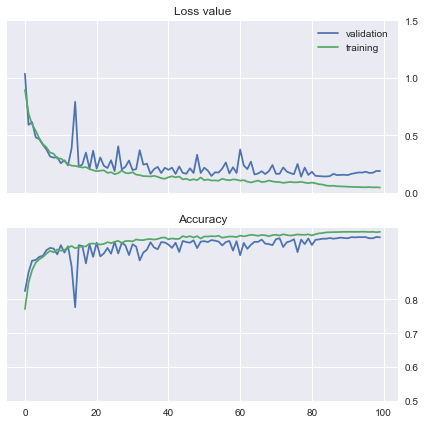

In [14]:
records     = pd.read_csv(folderpath+modelname +'.csv')
plt.figure()
plt.subplot(211)
plt.plot(records['val_loss'], label="validation")
plt.plot(records['loss'],label="training")
plt.yticks([0.00,0.50,1.00,1.50])
plt.title('Loss value',fontsize=12)

ax          = plt.gca()
ax.set_xticklabels([])

plt.subplot(212)
plt.plot(records['val_accuracy'],label="validation")
plt.plot(records['accuracy'],label="training")
plt.yticks([0.5,0.6,0.7,0.8])
plt.title('Accuracy',fontsize=12)
ax.legend()
plt.show()

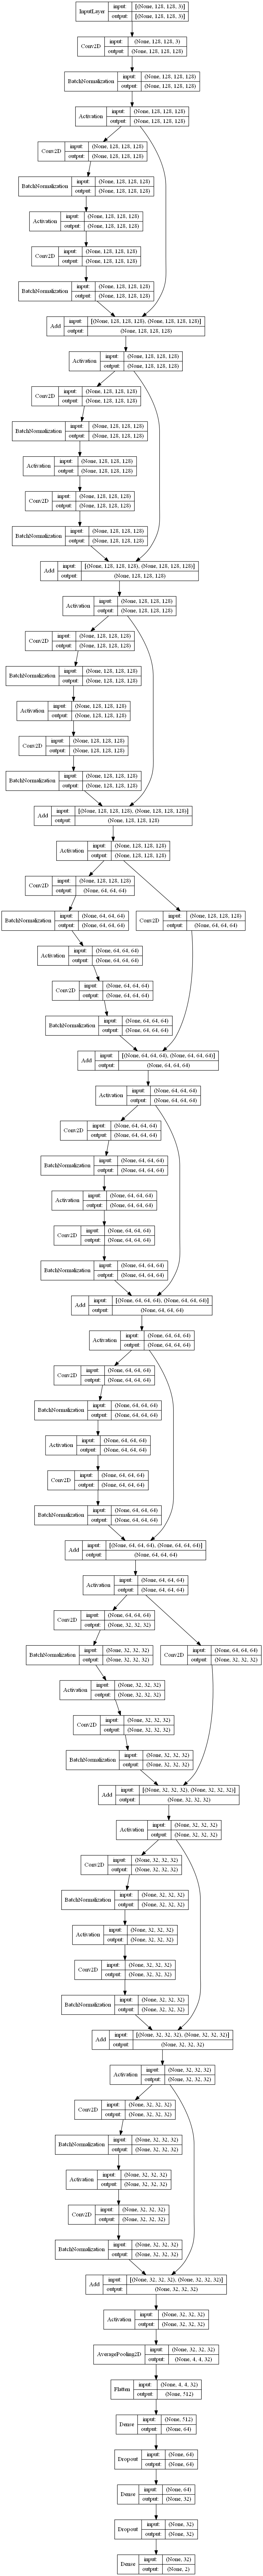

In [15]:
plotpath  = folderpath+modelname+'_plot.png'
plot_model(model, 
           to_file=plotpath, 
           show_shapes=True, 
           show_layer_names=False,
           rankdir='TB')


In [16]:
from tensorflow.python.client import device_lib
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_devices()) 

['/device:CPU:0', '/device:GPU:0']
